<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Projet TER analyse de données__

# IMPORTS & GLOBAL VARIABLES
----

In [1]:
!pip install pyreadstat

import os
import pandas as pd
import numpy as np
import pyreadstat as pt

import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/COLAB_STUFF/donnees/" # "../TER_M1_MIASHS/donnees/"

     |████████████████████████████████| 2.0MB 6.5MB/s 


La cellule suivante permet de vous connecter a votre google drive, vous pourrez ainsi lire et sauver des fichiers dans ce même drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A __read function__ to convert a .SAV file into a pandas.DataFrame, and a __concat function__ for later to merge all data

In [4]:
'''
desc : from a filename 'fichier' (with an ".sav" extension) returns a DataFrame
return : DataFrame
'''
def lire(fichier):
    df, meta = pt.read_sav(fichier)
    return df

'''
desc : save a dataframe as a CSV file
df : a dataframe to be saved
filename : a string, the path where the file should be saved
'''
def sauver(df, filename):
    return df.to_csv(filename)

'''
desc : concat multiple dataframe, joining the same columns and adding the ones that are different
dfs : a list of DataFrame
return : the concatenation of dfs
'''
def concat(dfs):
    res = dfs[0]
    for i in range(1, len(dfs)):
        res = res.merge(dfs[i], how="outer")
    return res

'''
desc : compute a csi score
X : a dataframe, answers to all five questions {"a":[0-7], "b":[0-7], "c":[0-7], "d":[0-7], "e":[0-7]}
    to compute the CSI score
return : a float, the computed CSI score
'''
def reduced_csi_score(X):
    csi = pd.DataFrame(columns=["answers", "weight", "weighted_score"])
    csi.answers = X
    csi.weight = [1,2,1,3,1] # les poids de chaque questions

    csi.weighted_score = csi.answers * csi.weight # le score pondéré pour chaque question
    # csi.score = csi.weighted_score.sum() # la somme des scores pondérés est le reduced CSI (cf. d-CSI dans la biblio)
    return csi.weighted_score.sum()

# FILE BY FILE
----

In [5]:
files = ["Base_SA_globale_20182019.sav", "cahier6_final_Prev_20172018.sav", "Cahier6_def_Prev_20162017.sav", "Cahier6_Prev_20152016.sav", "Cahier6_Prev_20142015.sav"]

In [6]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["Q1","Q2","Q3","Q4","Q5"],
    "target" : ["CSI"]
}
col_to_keep = col["metadata"] + col["data"] + col["target"]

In [7]:
dfs = {}
new_path = path + "formated/"
new_files = []

In [ ]:
for f in files:
    df = lire(path + f)

    annee = f.split('.')[0].split('_')
    annee = int(annee[len(annee)-1][:4])
    df["YEAR"] = annee

    try:
        df = df.rename(columns={"CODMEN" : "MEN"})
    except Exception as e:
        pass
    df[col["metadata"]] = df[col["metadata"]].astype(int) # convert all columns about location as int

    for i, column in enumerate(["S62Q1_1", "S62Q1_2", "S62Q1_3", "S62Q1_4", "S62Q1_5"]): # rename questions columns
        df = df.rename(columns={column : col["data"][i]})

    df[col["target"]] = np.nan # initialize CSI column
    # pour chaque MEN (donc chaque ligne) du dataframe on calcule le CSI réduit
    # (cf. la fonction "reduced_csi_score(X)")
    for i in range(df.shape[0]):
        d = df.iloc[i]
        d[col["target"]] = reduced_csi_score(d[col["data"]])
        df.iloc[i] = d

    df = df.loc[:, col_to_keep] # on réduit le dataframe au colonnes voulus

    filename = "donnees_" + str(annee) + ".csv" # nouveau nom de fichier
    new_files.append(filename) # on stock le nom de fichiers (au cas où)
    sauver(df, new_path + filename) # on sauvegarde le nouveau dataframe (dans le dossier "formated")

In [8]:
# dfs = {}
# new_path = path + "formated/"
# new_files = ["donnees_2014.csv", "donnees_2015.csv", "donnees_2016.csv", "donnees_2017.csv", "donnees_2018.csv"]

for _,_,files in os.walk(new_path):
    for f in files:
        annee = int(f.split('.')[0].split('_')[1])
        df = pd.read_csv(new_path + f)
        df = df.set_index(df.columns[0])
        df[col["metadata"]] = df[col["metadata"]].astype(int)
        dfs[annee] = df

In [9]:
'''
desc : print out a summary of data of a given dataframe
       
       compute the mean of CSI, missing values, the number of houseolds.
df : a dataframe, to be summed up
'''
def summary(df):
    print("NB ROWS : {}".format(df.shape[0]))
    print("COLUMNS : {}\n".format(list(df.columns)))

    print("{} HOUSEHOLDS".format(df.MEN.unique().shape[0]))
    print("{} VILLAGE".format(df.VIL.unique().shape[0]))
    print("{} COMMUNE".format(df.COM.unique().shape[0]))
    print("{} PROVINCE".format(df.PROV.unique().shape[0]))
    print("{} REGION".format(df.REG.unique().shape[0]))

    print()
    print(df[col["data"] + col["target"]].describe().to_markdown())

'''
desc : display some plots useful to see what's in the dataframe,
       such as CSI by town, or mean CSI by town ... (vraiment j'ai pas d'idée ...)
df : a dataframe, to be summed up
'''
def plot_question_csi(df):
    df = df.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

    g = sns.FacetGrid(df, col="QUESTION")
    g.map(sns.boxplot, "ANSWER", "CSI", order=df.ANSWER.unique().sort())
    return plt.show()


In [10]:
# print(dfs.keys())
annee = 2014
summary(dfs[annee])
# plot_question_csi(dfs[annee])

NB ROWS : 5198
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'CSI']

717 HOUSEHOLDS
67 VILLAGE
14 COMMUNE
45 PROVINCE
13 REGION

|       |         Q1 |          Q2 |          Q3 |          Q4 |          Q5 |        CSI |
|:------|-----------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5173       | 5165        | 5164        | 5163        | 5162        | 5198       |
| mean  |    1.06263 |    0.294482 |    0.998257 |    0.787914 |    0.944401 |    5.92016 |
| std   |    1.88676 |    0.932573 |    1.93628  |    1.76313  |    1.94285  |    9.82212 |
| min   |    0       |    0        |    0        |    0        |    0        |    0       |
| 25%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 50%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 75%   |    2       |    0        |    1        |    0        |    1        |    8       |
| ma

In [11]:
# annee = 2015
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [12]:
# annee = 2016
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [13]:
# annee = 2017
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [14]:
# annee = 2018
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

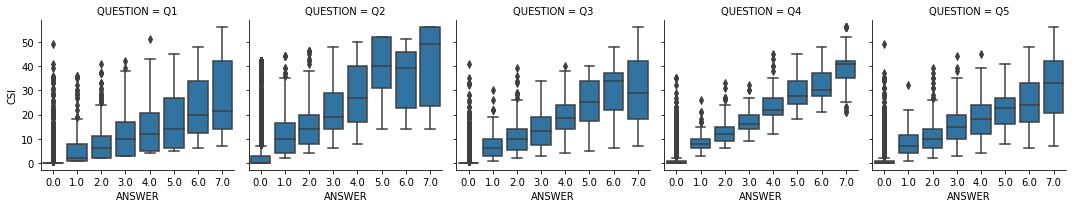

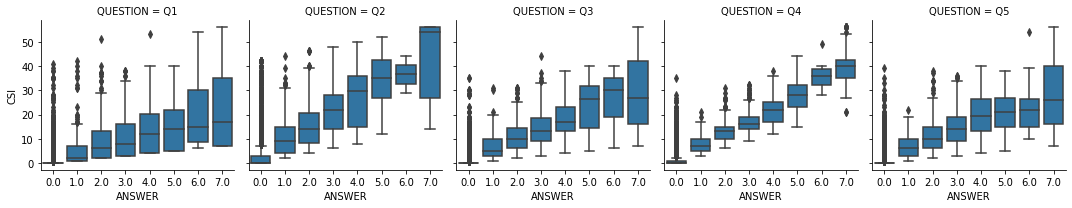

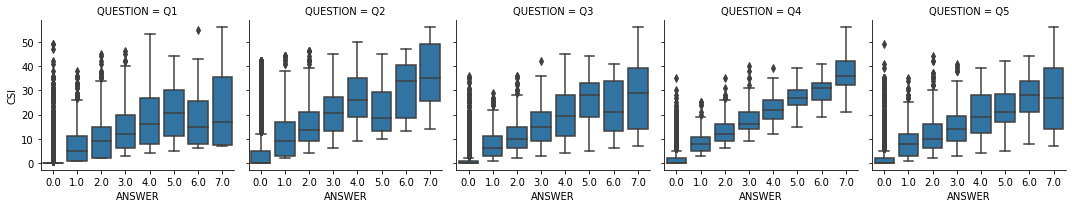

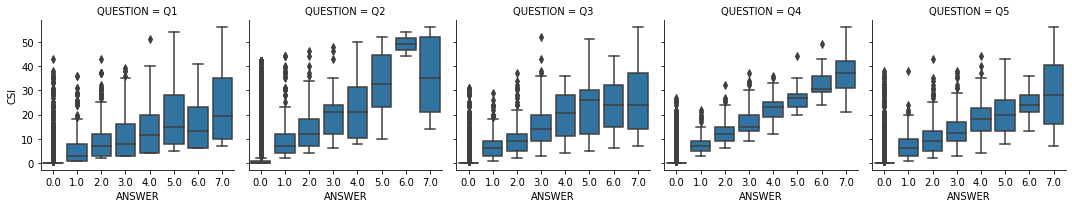

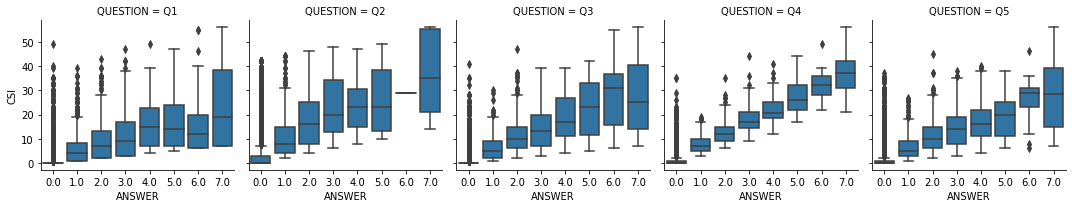

In [15]:
for k in dfs:
    df = dfs[k]
    plot_question_csi(df)

On remarque que beaucoup de valeurs sont à 0, pour pouvoir mieux remarquer la distribution nous allons effectuer le même affichage sans toutes les valeurs à 0.

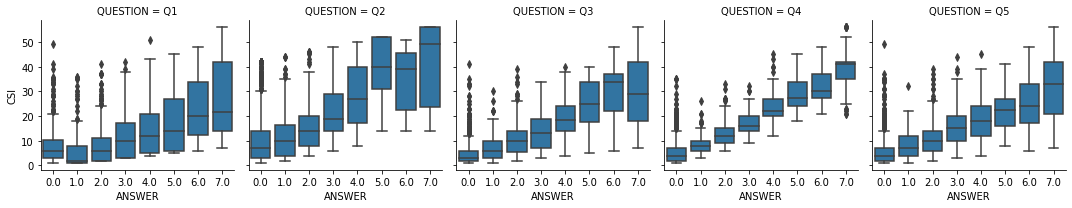

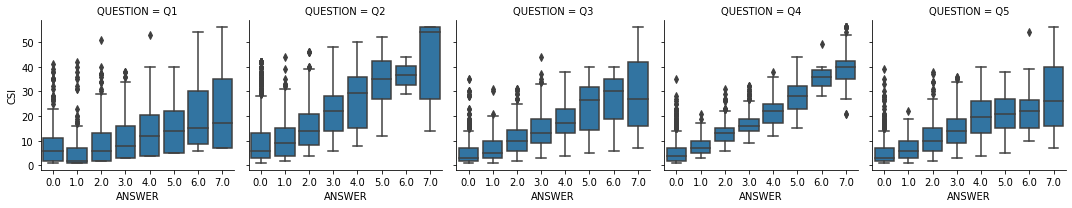

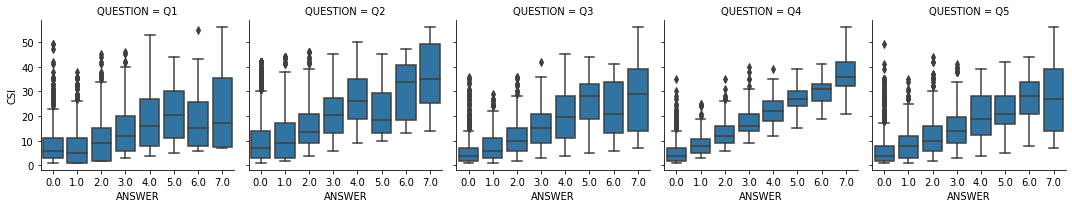

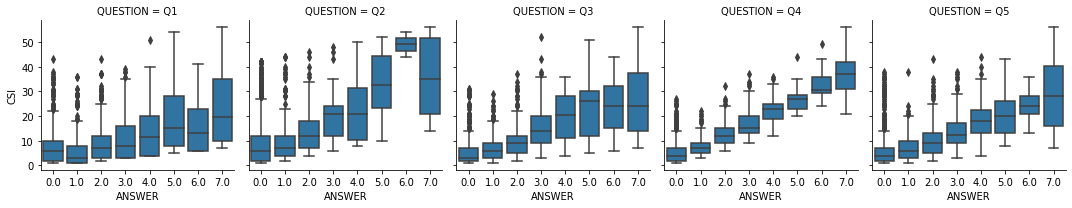

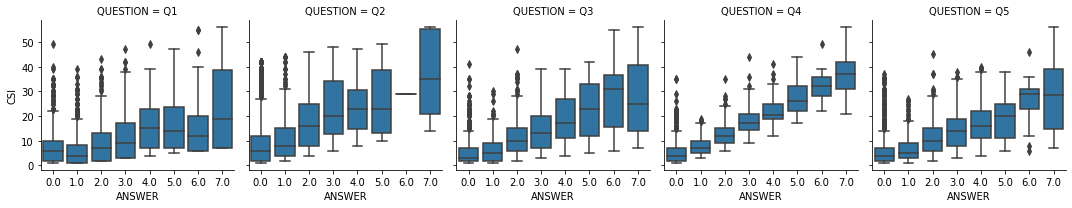

In [16]:
for k in dfs:
    df = dfs[k]
    df = df[df.CSI != 0.0]# on retire toutes les lignes avec CSI == 0.0
    plot_question_csi(df)

# CONCAT EVERY DATA FILE
----
Some functions we'll use to concat those files, we then add a column refering to the year of the file.

In [17]:
dfs_list = [dfs[2014], dfs[2015], dfs[2016], dfs[2017], dfs[2018]]
raw_data = concat(dfs_list)

# SAVES ALL DATA CONCATENED IN A CSV FILE
raw_data.to_csv(path + 'donnees.csv')

# raw_data = raw_data[raw_data.CSI != 0.0]
raw_data

,REG,PROV,COM,VIL,MEN,YEAR,Q1,Q2,Q3,Q4,Q5,CSI
0,1,13,1,1,45,2014,0.0,0.0,0.0,0.0,0.0,0.0
1,1,13,1,1,57,2014,0.0,0.0,0.0,0.0,0.0,0.0
2,1,13,1,1,58,2014,0.0,0.0,0.0,0.0,0.0,0.0
3,1,13,1,1,67,2014,0.0,0.0,0.0,0.0,0.0,0.0
4,1,13,1,1,84,2014,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25980,13,41,5,14,39,2018,2.0,0.0,1.0,1.0,1.0,7.0
25981,13,41,5,14,43,2018,2.0,0.0,1.0,1.0,1.0,7.0
25982,13,41,5,14,53,2018,1.0,0.0,0.0,1.0,0.0,4.0
25983,13,41,5,14,68,2018,2.0,0.0,2.0,1.0,0.0,7.0


In [18]:
summary(raw_data)

NB ROWS : 25985
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'CSI']

737 HOUSEHOLDS
70 VILLAGE
16 COMMUNE
45 PROVINCE
13 REGION

|       |           Q1 |           Q2 |           Q3 |           Q4 |           Q5 |         CSI |
|:------|-------------:|-------------:|-------------:|-------------:|-------------:|------------:|
| count | 25840        | 25716        | 25713        | 25703        | 25693        | 25985       |
| mean  |     0.943382 |     0.212475 |     0.803524 |     0.579932 |     0.738139 |     4.60454 |
| std   |     1.8117   |     0.813961 |     1.78521  |     1.53178  |     1.76967  |     8.94059 |
| min   |     0        |     0        |     0        |     0        |     0        |     0       |
| 25%   |     0        |     0        |     0        |     0        |     0        |     0       |
| 50%   |     0        |     0        |     0        |     0        |     0        |     0       |
| 75%   |     1        |     0        |

Nous allons d'abord regarder la corrélation entre chaque question et la valeur du CSI. (Le code provient de la gallerie officielle de Seaborn : https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

In [19]:
# Compute the correlation matrix
corr = raw_data[raw_data.CSI != 0.0].corr()
corr[corr.shape[0]-1:]

,REG,PROV,COM,VIL,MEN,YEAR,Q1,Q2,Q3,Q4,Q5,CSI
CSI,-0.012974,0.03684,-0.009832,-0.025694,-0.00072,-0.017685,0.460743,0.426999,0.708393,0.88134,0.69403,1.0


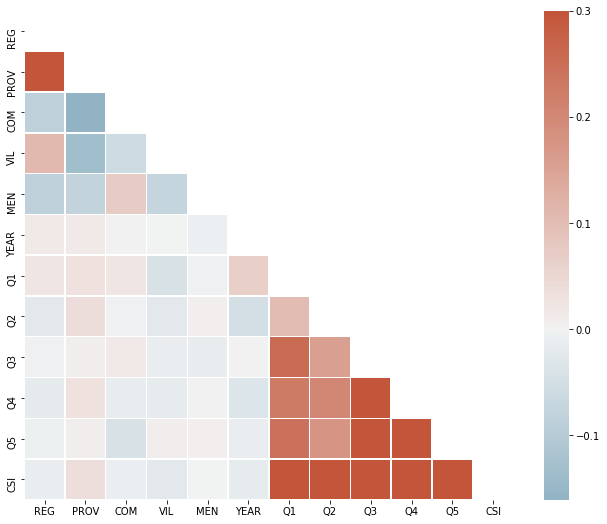

In [20]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})
plt.show()

On remarque donc que les questions ont toutes un impacte égal sur le CSI. De plus, on voit que l'attribut "PROV" semble avoir un impacte, certes plus faible que les colonnes "data" mais plus fort que les autres attributs de cette même classe "metadata", sur le CSI.

----

On va maintenant changer la structure du dataframe afin de pouvoir afficher correctement le comportement du CSI en fonction de différentes colonnes. Nous retirons de plus toutes les valeurs de CSI égales à 0, pour "alléger" l'affichage.

In [38]:
plot_data = raw_data[raw_data.CSI > 0.0]
plot_data = plot_data.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

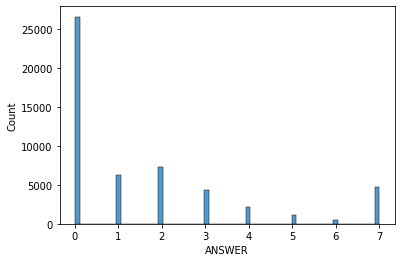

In [48]:
sns.histplot(plot_data.ANSWER)
plt.show()

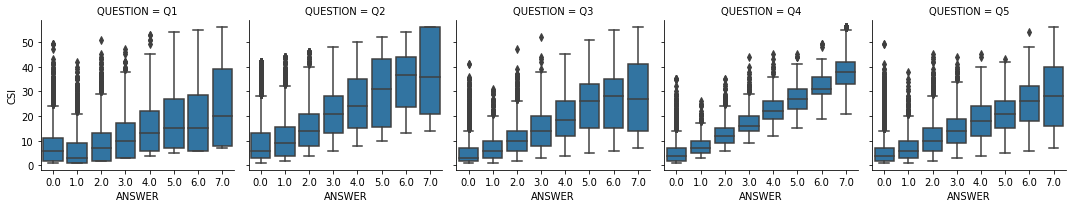

In [40]:
g = sns.FacetGrid(plot_data, col="QUESTION")
g.map(sns.boxplot, "ANSWER", "CSI", order=plot_data.ANSWER.unique().sort())
plt.show()

In [41]:
geo = "PROV"
col_wrap = 5

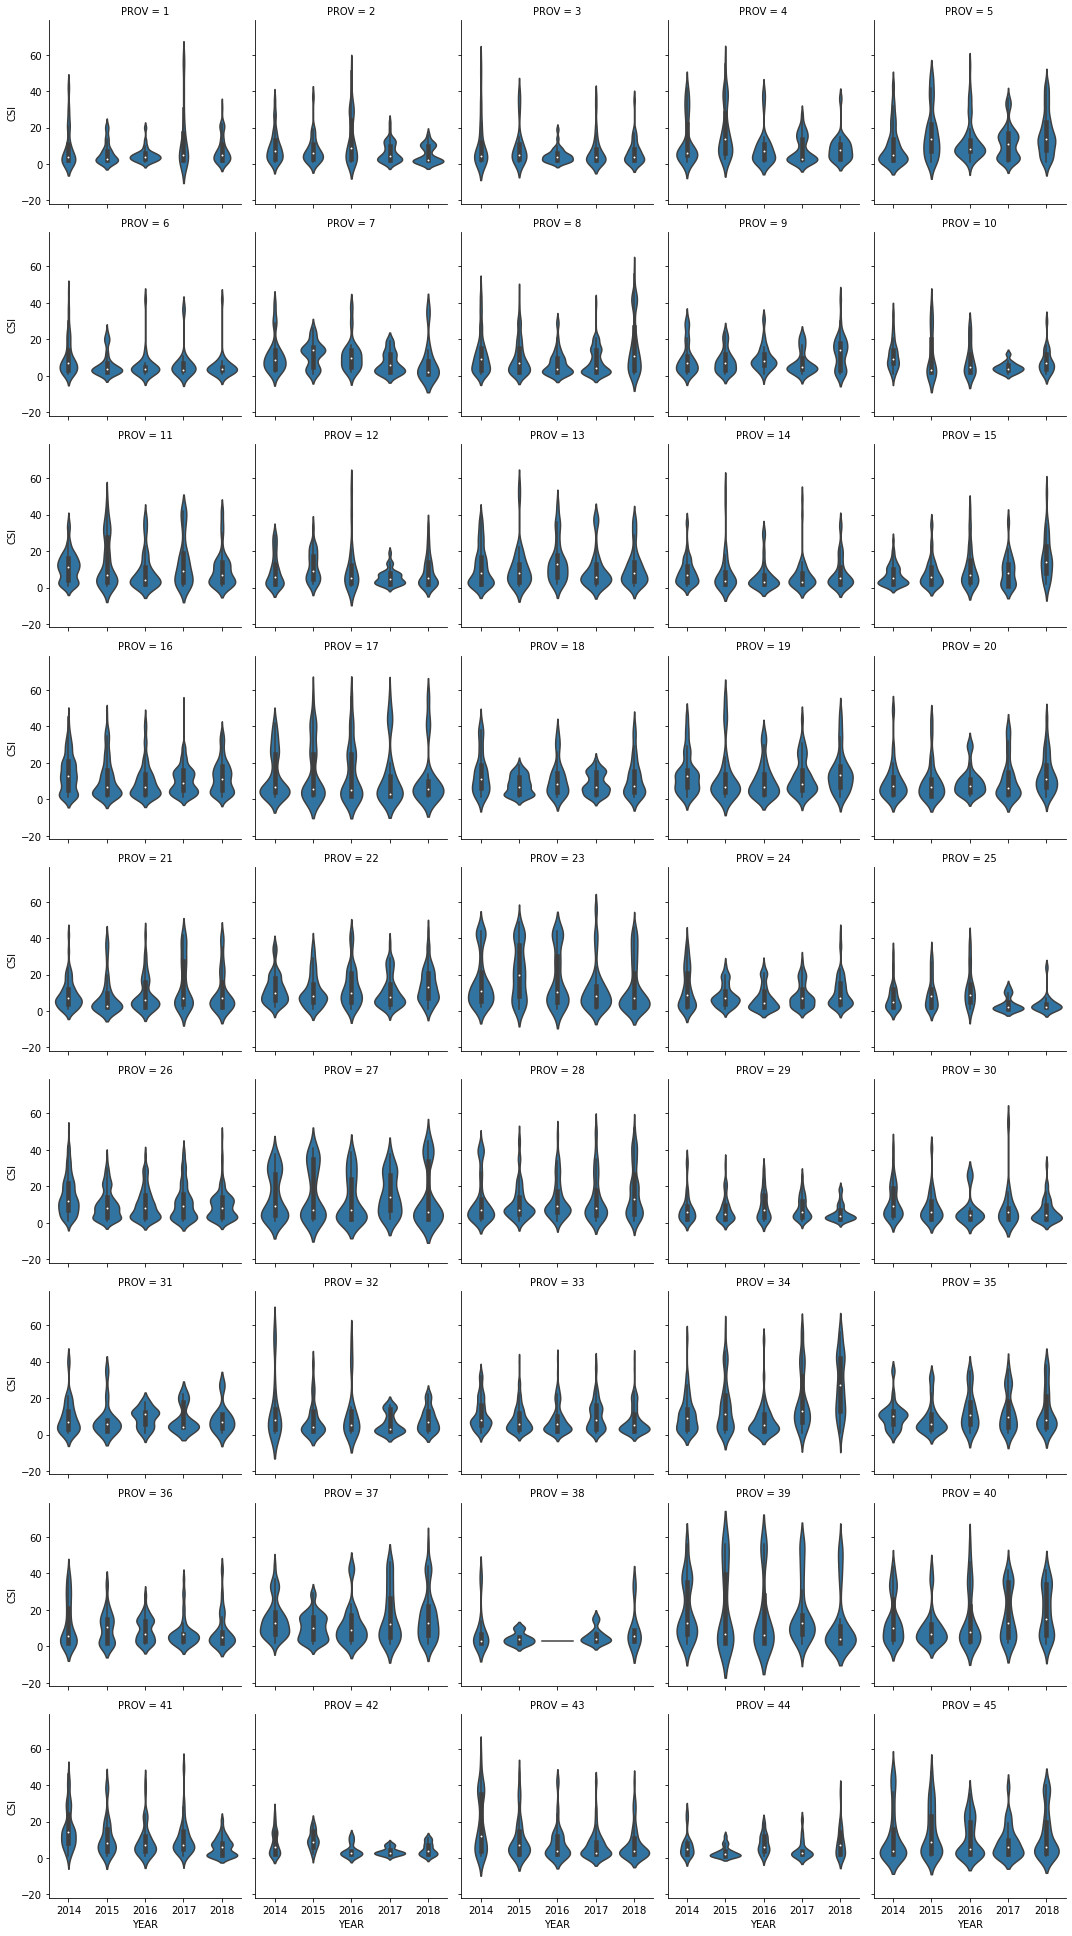

In [42]:
g = sns.FacetGrid(plot_data, col=geo, col_wrap=col_wrap)
g.map(sns.violinplot, "YEAR", "CSI", order=plot_data.YEAR.unique().sort())
plt.show()

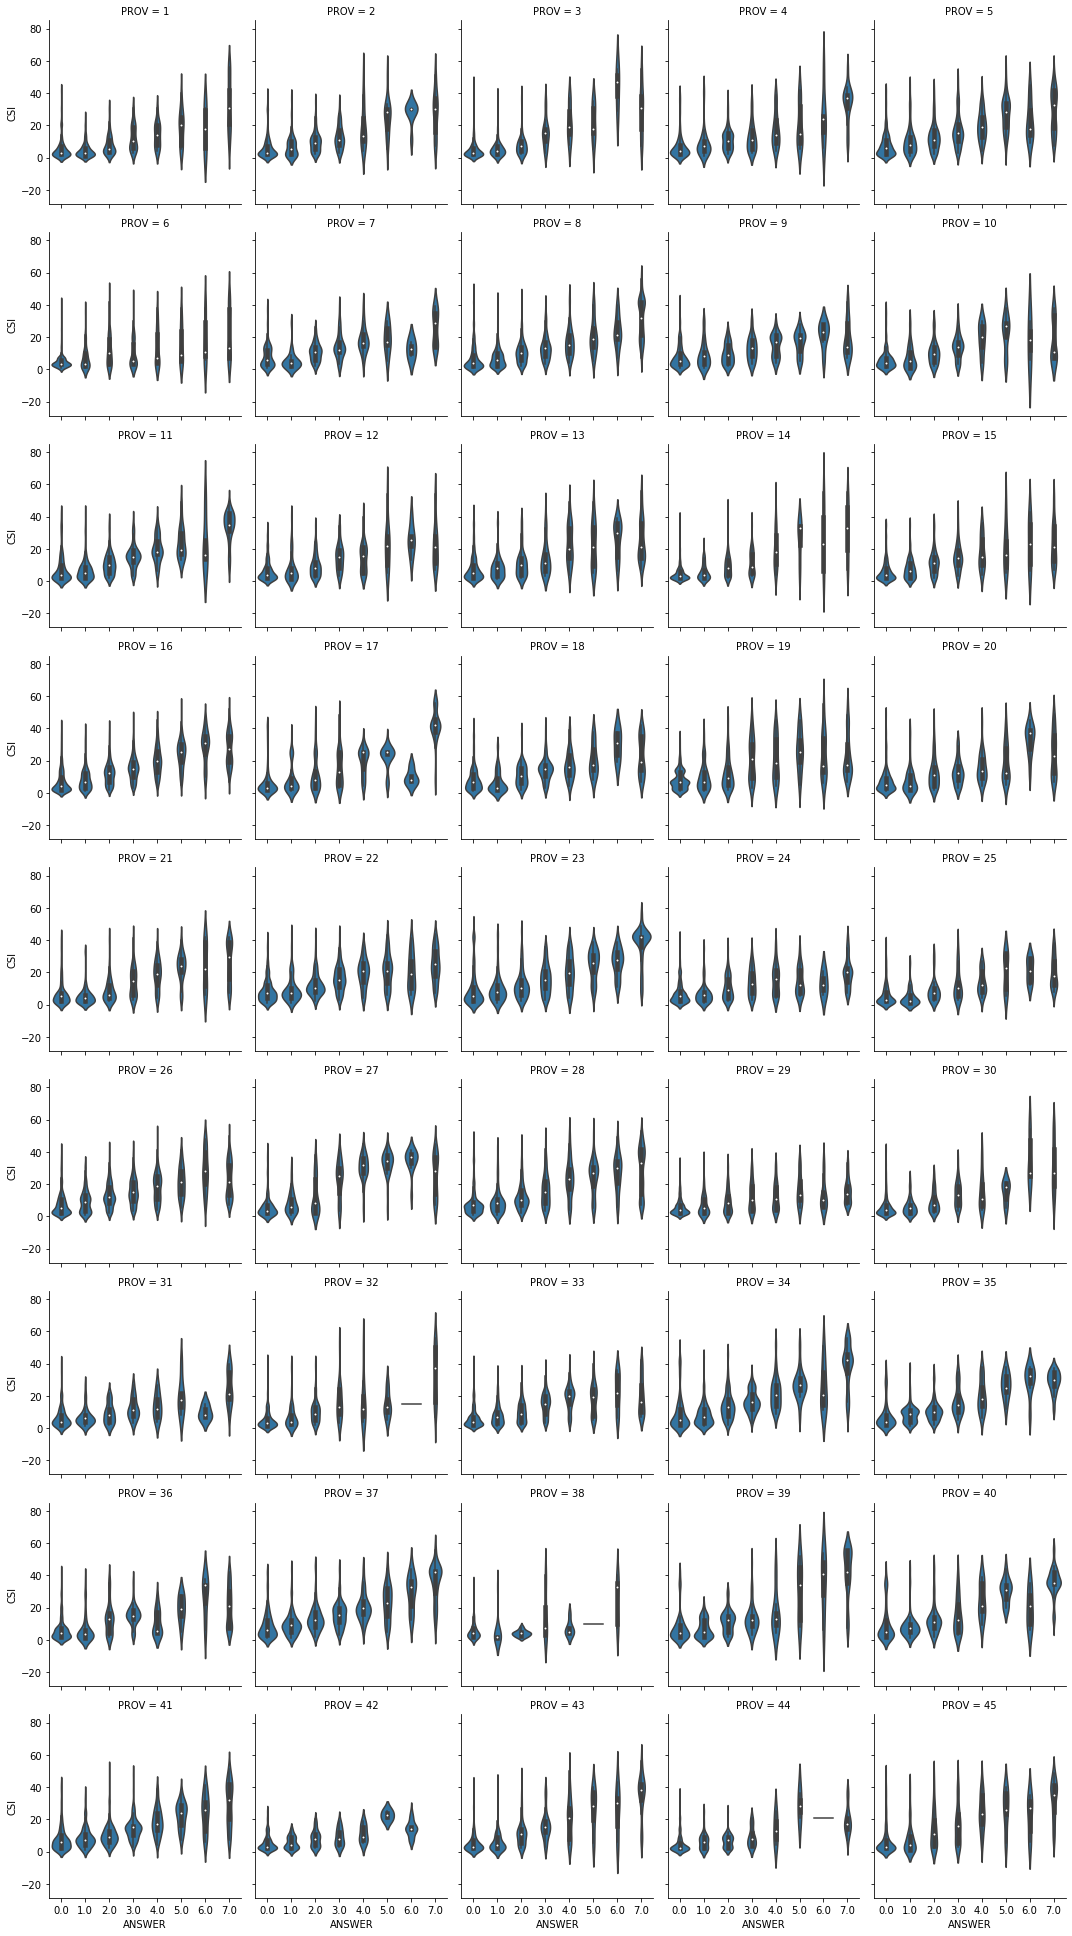

In [45]:
g = sns.FacetGrid(plot_data, col=geo, col_wrap=col_wrap)
g.map(sns.violinplot, "ANSWER", "CSI", order=plot_data.ANSWER.unique().sort())
plt.show()

# ANALYSE
----
Certaines colonnes ont des noms différents et représentant la même métrique, d'autres ne nous intéresse tout simplement pas.
On veut alors essayer de réduire le nombre de colonnes.

__D'abord quelques infos à propos du jeu de données__

In [ ]:
# for col in raw_data.columns:
#     print(col)

# FEATURE ENGINEERING
----
We'll see if there is any transformation needed in the data, we could also complete some rows by computing the CSI score.

# MODELING